# preparations

## install Qiskit

In [ ]:
%pip install qiskit qiskit_aer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 26.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 47.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 48.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.5/37.5 MB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.7/112.7 kB 11.9 MB/s eta 0:00:00


## loading necessary libraries

In [ ]:
from qiskit.circuit import QuantumCircuit, QuantumRegister, AncillaRegister, ClassicalRegister, ParameterVector
from qiskit.compiler import transpile
from qiskit import execute
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, pauli_error, ReadoutError, thermal_relaxation_error, depolarizing_error
from qiskit.quantum_info import Statevector, DensityMatrix, Operator

from qiskit.visualization import array_to_latex

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from timeit import default_timer as timer

## noise models:

### IonQ's Aria specifications:
depolarizing error probability is probabilities adjusted from thermal noise infidelity: $p = e^{-t/T_2}$ with gate time for $t$

In [ ]:
# error probabilities
p_meas = 3.9e-3
p_reset = 3.9e-3
p_gate1 = 6e-4
p_gate2 = 6e-3

# thermal relaxation error (nanosecond time)
T1s = np.random.choice(range(10, 100), 10, replace=False) # consider adjusting range to be more reasonable
T2 = 1e9

time_meas = np.random.choice(range(600, 700), 10, replace=False)
time_u1 = 0 # virtual gate
time_gate1 = 1.35e5 # u1 and u2
time_gate2 = 6e5 # 2 qubit gate

# thermal relaxation error
ther_u1  = [thermal_relaxation_error(t1 * 1e9, T2, time_u1)
              for t1 in T1s]
ther_gate1  = [thermal_relaxation_error(t1 * 1e9, T2, time_gate1)
              for t1 in T1s]
ther_gate2 = [[thermal_relaxation_error(t1a * 1e9, T2, time_gate2).expand(
             thermal_relaxation_error(t1b * 1e9, T2, time_gate2))
              for t1a in T1s]
               for t1b in T1s]

# depolarizing error
dep_reset = depolarizing_error(p_reset, 1)
dep_gate1 = depolarizing_error(p_gate1 - 1.34990888e-4, 1)
dep_gate2 = depolarizing_error(p_gate2 - 5.99820036e-4, 2)

# readout error
er_meas = ReadoutError([[1 - p_meas, p_meas], [p_meas, 1 - p_meas]])

# creating the noise model
fake_aria = NoiseModel()

for j in range(10):
    fake_aria.add_quantum_error(ther_u1[j].compose(dep_gate1), "u1", [j])
    fake_aria.add_quantum_error(ther_gate1[j].compose(dep_gate1), "u2", [j])
    fake_aria.add_quantum_error(ther_gate1[j].compose(dep_gate1), "u3", [j])
    for k in range(10):
        fake_aria.add_quantum_error(ther_gate2[j][k].compose(dep_gate2), "cx", [j, k])
fake_aria.add_all_qubit_quantum_error(dep_reset, "reset")
fake_aria.add_all_qubit_readout_error(er_meas)

### IonQ's Harmony specifications:

(it's basically all noise compared to Aria)

In [ ]:
h_p_meas = 1.8e-3
h_p_reset = 1.8e-3
h_p_gate1 = 4e-3
h_p_gate2 = 2.7e-2

# thermal relaxation error (nanosecond time)
h_T1s = np.random.choice(range(10, 100), 10, replace=False) # consider adjusting range to be more reasonable
h_T2 = 1e9

h_time_meas = np.random.choice(range(600, 700), 10, replace=False) # assumed same as aria
h_time_u1 = 0 # virtual gate?
h_time_gate1 = 1e4 # u1 and u2
h_time_gate2 = 2.1e5 # 2 qubit gate

# thermal relaxation error
h_ther_u1  = [thermal_relaxation_error(t1 * 1e9, h_T2, h_time_u1)
              for t1 in h_T1s]
h_ther_gate1  = [thermal_relaxation_error(t1 * 1e9, h_T2, h_time_gate1)
              for t1 in h_T1s]
h_ther_gate2 = [[thermal_relaxation_error(t1a * 1e9, h_T2, h_time_gate2).expand(
             thermal_relaxation_error(t1b * 1e9, h_T2, h_time_gate2))
              for t1a in h_T1s]
               for t1b in h_T1s]

# depolarizing error
h_dep_reset = depolarizing_error(h_p_reset, 1)
h_dep_gate1 = depolarizing_error(h_p_gate1 - 9.99995e-6, 1)
h_dep_gate2 = depolarizing_error(h_p_gate2 - 2.09977952e-4, 2)

# readout error
h_er_meas = ReadoutError([[1 - p_meas, p_meas], [p_meas, 1 - p_meas]])

fake_harmony = NoiseModel()

for j in range(10):
    fake_harmony.add_quantum_error(h_ther_u1[j].compose(h_dep_gate1), "u1", [j])
    fake_harmony.add_quantum_error(h_ther_gate1[j].compose(h_dep_gate1), "u2", [j])
    fake_harmony.add_quantum_error(h_ther_gate1[j].compose(h_dep_gate1), "u3", [j])
    for k in range(10):
        fake_harmony.add_quantum_error(h_ther_gate2[j][k].compose(h_dep_gate2), "cx", [j, k])
fake_harmony.add_all_qubit_quantum_error(h_dep_reset, "reset")
fake_harmony.add_all_qubit_readout_error(h_er_meas)

## Grover parameter finder: this optimizes `delta` $\in (0, 1)$ so that the query complexity is minimal for a given pair of target probability and ratio, `P` and `Lambda`

note #1: for target probability $\sim$ 90%, it helps as long as `Lambda` $\gg$ `1e-4`

note #2: there ought to be a simpler, analytic version of this

In [ ]:
# L, x must be positive
def Chebyshev(L:  float, x: float):
    return np.cos(L * np.arccos(x)) if x <= 1 else np.cosh(L * np.arccosh(x))

# delta, Lambda must be in (0, 1)
def GroverQueryComplexity(delta: float, Lambda: float):
    return int(np.ceil(np.arccosh(1 / delta) / np.arccosh(1 / np.sqrt(1 - Lambda)))) // 2

# Lambda must be in (0, 1)
def GroverProbability(delta: float, Lambda: float):
    L = 2 * GroverQueryComplexity(delta, Lambda) + 1
    return 1 - np.power(delta * Chebyshev(L, Chebyshev(1 / L, 1 / delta) * np.sqrt(1 - Lambda)), 2)

# P, Lambda must be in (0, 1), N must be a positive integer
def GroverParameterOptimizerForProbability(P: float, Lambda: float, N: int):
    step, L, p = np.exp2(- N), 0, 0
    done = False
    while p < P:
        L += 1
        d = step
        l = GroverQueryComplexity(d, Lambda)
        while l > L:
            d += step
            l = GroverQueryComplexity(d, Lambda)
        delta = d
        while d < 1:
            p_new = GroverProbability(d, Lambda)
            if p_new >= p:
                p, delta = p_new, d
            d += step
            l = GroverQueryComplexity(d, Lambda)

    return delta

# Lambda must be in (0, 1), l, N must be positive integers
def GroverParameterOptimizerForComplexity(l: int, Lambda: float, N: int):
    deltas = np.where(np.int8(np.ceil(np.arccosh(1 / np.linspace(1 - np.exp2(- N), np.exp2(- N), 1 << N)) / np.arccosh(1 / np.sqrt(1 - Lambda)))) // 2 <= l, np.linspace(1 - np.exp2(- N), np.exp2(- N), 1 << N), 0)
    delta, prob = deltas[0], GroverProbability(deltas[0], Lambda)
    for d in deltas[1: np.where(deltas == 0)[0][0]]:
        if GroverProbability(d, Lambda) > prob:
            delta, prob = d, GroverProbability(d, Lambda)

    return delta

# Grover Fixed Point Search for gerenal Quadratic Binary Optimization problems

In [ ]:
def GroverFPSForQUBO(QuadraticForm: list[list[int]], digits: int, threshold: int, delta: float, Lambda: float):

    # parameters
    l = int(np.ceil(np.arccosh(1 / delta) / np.arccosh(1 / np.sqrt(1 - Lambda)))) // 2
    gamma = 1 / np.tanh(np.arccosh(1 / delta) / (2 * l + 1))
    GroverPhases = 2 * np.arctan2(gamma, np.tan(np.arange(1, l + 1) * 2 * np.pi / (2 * l + 1)))

    # circuit preparation
    QRegX = QuantumRegister(len(QuadraticForm), "x") # quantum registers for the bit configurations
    QControl, QTarget = QRegX[:-1], QRegX[-1] # this is just to make the multi-controlled phase gate's code a bit less confusing
    QRegY = AncillaRegister(digits, "y") # quantum registers to digitize values

    QC = QuantumCircuit(QRegX, QRegY, name=f"Grover FPS Circuit")

    # state-preparation
    QC.h(QRegX[:] + QRegY[:])

    # adding threshold - 1
    for i, q in enumerate(reversed(QRegY)):
        QC.rz((threshold - 1) * np.exp2(- i) * np.pi, q)

    # Grover FPS bang-bangs
    for alpha, beta in zip(GroverPhases, reversed(GroverPhases)):

        # S_t (beta)

        # subtracting the quadratic form's value
        for i, q in enumerate(QRegX):

            # subtracting the row contributions
            if np.sum(QuadraticForm[i]) != 0:
                for j, p in enumerate(reversed(QRegY)):
                    QC.cp(- np.sum(QuadraticForm[i]) * np.exp2(- j) * np.pi, q, p)

            # subtracting the x_i XOR x_j contributions
            for j, p in enumerate(QRegX[i + 1:]):
                if QuadraticForm[i][i + 1 + j] != 0:
                    QC.cx(q, p)
                    for k, r in enumerate(reversed(QRegY)):
                        QC.cp(QuadraticForm[i][i + 1 + j] * np.exp2(- k) * np.pi, p, r)
                    QC.cx(q, p)

        # inverse QFT without the SWAPs
        for i, q in enumerate(reversed(QRegY)):
            QC.h(q)
            for j, r in enumerate(reversed(QRegY[:- i - 1])):
                QC.cp(- np.pi * np.exp2(- (j + 1)), q, r)

        QC.p(beta, QRegY[0])

        # QFT without the SWAPs
        for i, q in enumerate(QRegY):
            QC.h(q)
            for j, r in enumerate(QRegY[i + 1:]):
                QC.cp(np.pi * np.exp2(- (j + 1)), q, r)

        # adding back the quadratic form's value
        for i, q in enumerate(QRegX):

            # adding back the row contributions
            if np.sum(QuadraticForm[i]) != 0:
                for j, p in enumerate(reversed(QRegY)):
                    QC.cp(np.sum(QuadraticForm[i]) * np.exp2(- j) * np.pi, q, p)

            # adding back the x_i XOR x_j contributions
            for j, p in enumerate(QRegX[i + 1:]):
                if QuadraticForm[i][i + 1 + j] != 0:
                    QC.cx(q, p)
                    for k, r in enumerate(reversed(QRegY)):
                        QC.cp(- QuadraticForm[i][i + 1 + j] * np.exp2(- k) * np.pi, p, r)
                    QC.cx(q, p)

        # S_s (alpha) / this implementation is only better when len(QuadraticForm) > 4
        QC.h(QRegX)
        QC.x(QRegX)

        for i, q in enumerate(reversed(QControl[1:])):
            for j, p in enumerate(QControl[len(QControl) - i:]):
                QC.crx(np.pi * np.exp2(- (j + 1)), q, p)
            QC.cp(alpha * np.exp2(- (i + 1)), q, QTarget)

        for i, q in enumerate(QControl[1:]):
            QC.crx(np.pi * np.exp2(- i), QControl[0], q)
            QC.cp(- alpha * np.exp2(i + 1 - len(QControl)), q, QTarget)
            for j, p in enumerate(QControl[i + 2:]):
                QC.crx(- np.pi * np.exp2(- (j + 1)), q, p)

        QC.cp(alpha * np.exp2(1 - len(QControl)), QControl[0], QTarget)

        for i, q in enumerate(reversed(QControl[1:])):
            for j, p in enumerate(QControl[len(QControl) - i:]):
                QC.crx(np.pi * np.exp2(- (j + 1)), q, p)

        for i, q in enumerate(QControl[1:]):
            QC.crx(- np.pi * np.exp2(- i), QControl[0], q)
            for j, p in enumerate(QControl[i + 2:]):
                QC.crx(- np.pi * np.exp2(- (j + 1)), q, p)

        QC.x(QRegX)
        QC.h(QRegX)

    return QC

# parameters & testing for MaxCut:

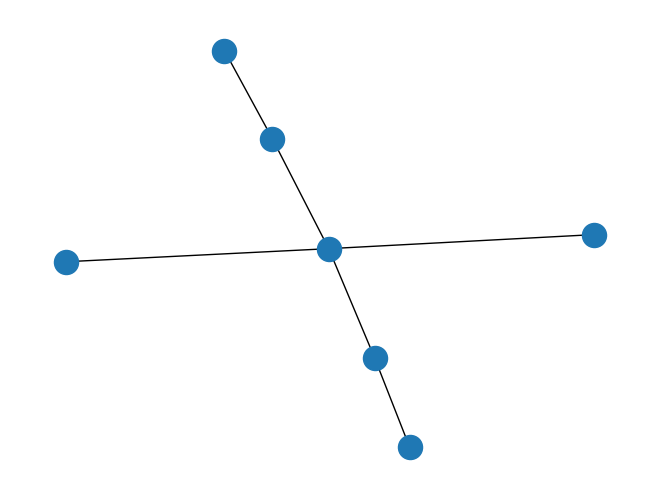

In [ ]:
# random, connected graph
NumberOfVertices, EdgeProbability = 7, 5e-1
Graph = nx.erdos_renyi_graph(NumberOfVertices, EdgeProbability)
while not nx.is_connected(Graph):
    Graph = nx.erdos_renyi_graph(NumberOfVertices, EdgeProbability)
nx.draw(Graph, with_labels=False)

GraphLaplacian = nx.laplacian_matrix(Graph).toarray()
NumberOfEdges = np.trace(GraphLaplacian) // 2
threshold = int(np.ceil((2 * NumberOfEdges + NumberOfVertices - 1)/4))
digits = 1 + int(np.ceil(np.log2(threshold))) if NumberOfVertices > 2 else 1 # number of ancilla qubits needed to digitize cuts

# let's get rid of the vertex with the highest degree; this step, is not necessary, but saves one qubit
maxdegvertex = np.where(np.diag(GraphLaplacian) == max(np.diag(GraphLaplacian)))[0][0]
if maxdegvertex + 1 != NumberOfVertices:
    GraphLaplacian[[maxdegvertex, -1], :] = GraphLaplacian[[-1, maxdegvertex], :]
    GraphLaplacian[:, [maxdegvertex, -1]] = GraphLaplacian[:, [-1, maxdegvertex]]
QuadraticForm = GraphLaplacian[np.ix_(np.arange(NumberOfVertices - 1), np.arange(NumberOfVertices - 1))]

# classical, brute-force cut-function and MaxCut computation
cuts = np.empty(1 << len(QuadraticForm), dtype=int)
for x, _ in enumerate(cuts):
    conf = (x >> np.arange(len(QuadraticForm)))&1
    cuts[x] = np.dot(np.matmul(conf, QuadraticForm), conf)
MaxCut = max(cuts)

# cut statistics
RandomChance, Lambda, m, sigma = np.array([np.sum(np.where(cuts == cut, 1, 0)) for cut in range(MaxCut + 1)]) * np.exp2(1 - NumberOfVertices), np.sum(np.where(cuts >= threshold, 1, 0)) * np.exp2(1 - NumberOfVertices), NumberOfEdges / 2, np.std(cuts)

In [ ]:
l = 1
delta = GroverParameterOptimizerForComplexity(l, Lambda, 12)
TargetProbability = GroverProbability(delta, Lambda)

print(f"MaxCut\tthreshold\tLambda\ttarget probability\tdelta\tl\tdigits\n{MaxCut}\t{threshold}\t\t{np.round(Lambda, 2)}\t{TargetProbability:.2%}\t\t\t{np.round(delta, 2)}\t{l}\t{digits}\n")

MaxCut	threshold	Lambda	target probability	delta	l	digits
6	5		0.11	70.15%			0.94	1	4



### simulation and evaluation of data:

In [ ]:
noise = True
#noise = False

print(f"\ncomputation with Grover Fixed Point Search...\n")
StartTime = timer()

QC = GroverFPSForQUBO(QuadraticForm, digits, threshold, delta, Lambda)

if noise:
    QC.save_density_matrix(qubits=QC.qubits[:-QC.num_ancillas],
                           label="ϱ")
    simulator = AerSimulator(method="density_matrix",
                             noise_model=fake_aria)
    QC = transpile(circuits=QC,
                   backend=simulator,
                   optimization_level=3)
    psi = simulator.run(QC, shots=1).result().data()["ϱ"]
else:
    QC.save_statevector()
    simulator = AerSimulator(method="statevector")
    QC = transpile(circuits=QC,
                   backend=simulator,
                   basis_gates=["h", "rx", "ry", "rz", "cx", "save_statevector"],
                   optimization_level=3)
    psi = Statevector(execute(QC, simulator).result().get_statevector())

EndTime = timer()
print(f"done in {np.round(EndTime - StartTime, 2)} seconds\n")


computation with Grover Fixed Point Search...

done in 7.93 seconds



In [ ]:
probabilities = psi.probabilities(np.arange(QC.num_qubits - QC.num_ancillas))
distribution, success = np.array([np.sum(np.where(cuts == cut, probabilities, 0)) for cut in range(MaxCut + 1)]), np.sum(np.where(cuts >= threshold, probabilities, 0))
M = np.sum(np.arange(len(distribution)) * distribution)
var = np.sqrt(np.sum(np.arange(len(distribution)) * np.arange(len(distribution)) * distribution) - M**2)
sign_m, sign_sigma = "+" if M >= m else "-", "+" if var >= sigma else "-"
CNOTCount = QC.count_ops()["cx"]

In [ ]:
s = f"simulation with"
s += f"" if noise else f"out"
s += f" noise\n\nthe graph:\n----------\nMaxCut\t\t\t\t= {MaxCut}\nnumber of edges\t\t\t= {NumberOfEdges}\n"
s += f"threshold (Erdős-Edwards bound)\t= {threshold} ({threshold/MaxCut:.1%} of MaxCut)"
s += f"\n\nthe graph Laplacian:\n--------------------\n\n" + f"".join([f"{row.view()}\n" for row in GraphLaplacian])
s += f"\nGrover parameters:\n------------------\nLambda\t\t\t= {np.round(Lambda, 2)}\ndelta\t\t\t= {np.round(delta, 2)}"
s += f"\nquery complexity\t= {l} (vanilla Grover = {int(np.rint(np.pi / (4 * np.sqrt(Lambda))))})\n\nresults with Grover:\n--------------------\n\n"
s += f"success probability\t= {success:.1%} (theoretical value = {TargetProbability:.1%}, random chance = {Lambda:.1%})\n"
s += f"speedup\t\t\t= {np.round(np.log1p(- success)/np.log1p(- Lambda), 2)}\n\n"
s += f"expectation\t\t= {np.round(M, 1)}\t({m} {sign_m} {np.round(abs(M - m), 1)})\n"
s += f"variance\t\t= {np.round(var, 1)}\t({np.round(sigma, 1)} {sign_sigma} {np.round(abs(var - sigma), 1)})\n\n"
s += f"CNOT count\t\t= {CNOTCount}\ncircuit depth\t\t= {QC.depth()}"
print(s)

simulation with noise

the graph:
----------
MaxCut				= 6
number of edges			= 6
threshold (Erdős-Edwards bound)	= 5 (83.3% of MaxCut)

the graph Laplacian:
--------------------

[ 1  0  0  0  0  0 -1]
[ 0  2 -1  0  0  0 -1]
[ 0 -1  1  0  0  0  0]
[ 0  0  0  1  0  0 -1]
[ 0  0  0  0  2 -1 -1]
[ 0  0  0  0 -1  1  0]
[-1 -1  0 -1 -1  0  4]

Grover parameters:
------------------
Lambda			= 0.11
delta			= 0.94
query complexity	= 1 (vanilla Grover = 2)

results with Grover:
--------------------

success probability	= 31.9% (theoretical value = 70.1%, random chance = 10.9%)
speedup			= 3.32

expectation		= 3.5	(3.0 + 0.5)
variance		= 1.4	(1.2 + 0.2)

CNOT count		= 192
circuit depth		= 262


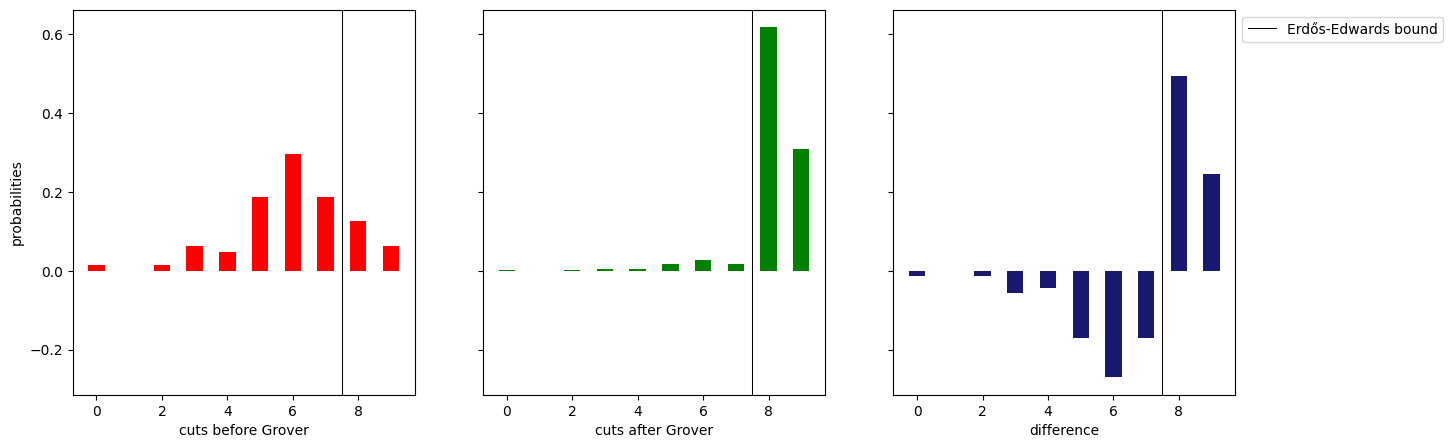

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(15, 5))

axs[0].bar(np.arange(len(RandomChance)),
           RandomChance,
           width=0.5,
           color="red")
axs[0].set(xlabel=f"cuts before Grover",
           ylabel=f"probabilities")
axs[0].axvline(x = threshold - 1/2,
               linewidth=0.75,
               color="black")

axs[1].bar(np.arange(len(distribution)),
           distribution,
           width=0.5,
           color="green")
axs[1].set(xlabel=f"cuts after Grover")
axs[1].axvline(x = threshold - 1/2,
               linewidth=0.75,
               color="black")

axs[2].bar(np.arange(len(distribution)),
           distribution - RandomChance,
           width=0.5,
           color="midnightblue")
axs[2].set(xlabel=f"difference")
axs[2].axvline(x = threshold - 1/2,
               linewidth=0.75,
               color="black",
               label=f"Erdős-Edwards bound")

plt.legend(bbox_to_anchor = (1.0, 1), loc = "upper left")

plt.show()

# Adaptive search